## Neural Network Notebook ##

A first draft of the neural network that will be used for the ECG classification project is described in this notebook.

### Initialization ###

We will train our model  with the help of the TensorFlow framework. If you had not installed TensorFlow yet, you can do it easily with the command pip install --upgrade tensorflow.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras


### Part 1 : importing the data ###

We start by importing our tests data. 

NOTE : training and testing datas can be in the same directory, we can seperate them directly with tensorflow.

NOTE2 : 
What is batch size ? 
Batch size is the number of samples you put into for each training round.
So for each epoch, you can split your training sets into multiple batches.
For example, I have 1000 images.
If I set my batch size to 1, then for each epoch (training round), my input into the network will be 1 x 1000 images.
If set my batch size to 2, then it will be 2 x 500 images.
Meaning, for each epoch, I will run two rounds, each round using 500 images.
Step is just the learning rate that you use for your optimizer.
Usually, we start with 0.001 or 0.01.

NOTE3 : Augmentation method

Found 144 files belonging to 6 classes.
Using 116 files for training.
Found 144 files belonging to 6 classes.
Using 28 files for validation.


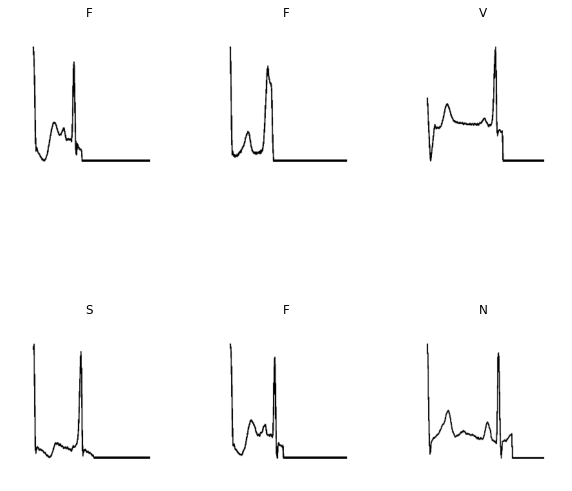

In [25]:

traindata=tf.keras.utils.image_dataset_from_directory(
  "Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="training",
  seed=123)

valdata=tf.keras.utils.image_dataset_from_directory(
  "Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="validation",
  seed=123)


plt.figure(figsize=(10, 10))
for images, labels in traindata.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(traindata.class_names[labels[i]])
    plt.axis("off")



In [16]:
for image_batch, labels_batch in traindata: 
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


image_bacth shape (32,256,256,3) means a group of 32 images of size 256x256 and the last channel 3 corresponds to the RVB colors reference. 
labels_batch shape (32,) corresponds to the label of the 32 images. 

NOTE : Why 32 ???

### Part 2 : pre-processing the data ###

#### Data standardization ###

For now, RVB channels are in [0,255] which is too large for a neural network. We will then normalize these values. 

NOTE : use only one channel for black and white pictures : search code to convert to black and white.

NOTE 2 :  Rescaling the image can be directly implemented in the model by layer.Rescaling

In [26]:
normalization_layer= tf.keras.layers.Rescaling(1./255)

normtraindata=traindata.map(lambda x, y: (normalization_layer(x),y))

### Part 3 :  creating the model ###

In this part, we define important elements that will be used to build our model. 

NOTE : This model is the one used in the Image Classification tutorial from TensorFlow website, same for the compiler. NEED TO BE RETHINKED AND DISCUSSED. 

PADDING : start with 'Valid' --> 'Same', keep as much information as possible

ACTIVATION function : can be changed also 

FLATTEN : flattening/mapping the pixels

POOLING : change between Max/Average ?

In [27]:
# Model Creation

model= keras.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'), 
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(6)
])

model.build((None,256,256,3))

#Model Compiler
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#Model summary 
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 64)     

### Part 3 : training and testing ###

Note : This code is taken from the TensorFlow tutorial page. 

In [29]:
epochs= 50
history = model.fit(
  normtraindata,
  validation_data=valdata,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

model.save("model/model_50E_8_2_bw.h5")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Epoch 1/30
10/10 [==============================] - 5s 478ms/step - loss: 1.9425 - accuracy: 0.7328 - val_loss: 8.0064 - val_accuracy: 0.2143
Epoch 2/30
10/10 [==============================] - 5s 451ms/step - loss: 1.3424 - accuracy: 0.6552 - val_loss: 2.7607 - val_accuracy: 0.2143
Epoch 3/30
10/10 [==============================] - 4s 429ms/step - loss: 1.3370 - accuracy: 0.5690 - val_loss: 7.9891 - val_accuracy: 0.2143
Epoch 4/30
10/10 [==============================] - 4s 438ms/step - loss: 1.3034 - accuracy: 0.6724 - val_loss: 7.9484 - val_accuracy: 0.2143
Epoch 5/30
10/10 [==============================] - 4s 428ms/step - loss: 1.3656 - accuracy: 0.6724 - val_loss: 5.4158 - val_accuracy: 0.2143
Epoch 6/30
 7/10 [====================>.........] - ETA: 1s - loss: 1.8970 - accuracy: 0.6905

KeyboardInterrupt: 

### Part 4 : Testing a random image on the model ###

Very simple code to quickly test some predictions on our model. Has to be improved. 

In [ ]:
predata=tf.keras.utils.image_dataset_from_directory("Small_dataset\S_prediction_datas_labels_bw")

predata2 = predata.unbatch()
labels = list(predata2.map(lambda x, y: y))
labels_brut=[]

for i in range(len(labels)):
    labels_brut.append(tf.get_static_value(labels[i]))

#Labels of the predicting outputs
print(labels_brut) 

dict={0:"F",1:"M",2:"N",3:"Q",4:"S",5:"V"}
prediction = model.predict(predata) 

classes = np.argmax(prediction, axis = 1)

for i,clas in enumerate(classes) :
    print(f"Image {i} is disease "+dict[clas] +" but should be "+dict[labels_brut[i]]) 
    





Found 6 files belonging to 6 classes.
[4, 0, 5, 2, 3, 1]
1/1 [==============================] - 0s 66ms/step
Image 0 is disease M but should be S
Image 1 is disease Q but should be F
Image 2 is disease S but should be V
Image 3 is disease Q but should be N
Image 4 is disease F but should be Q
Image 5 is disease N but should be M
[[ 1360.6224   7387.3823   1848.4061   2614.4507   3326.119    3343.976  ]
 [  580.7877   1238.7675   3266.6072   5885.42     1601.4751   4693.0864 ]
 [-1823.8557   3855.965     343.39365  4202.507    8856.944    4098.0806 ]
 [  368.47232  2196.679    2048.9124   5287.574    1463.9518   2708.1418 ]
 [ 6283.776    -473.82742  2260.1033    529.5229   -252.67456  1421.6614 ]
 [ 1806.655    2655.4146   4409.145    1309.2714    743.7094   1856.7938 ]]


InvalidArgumentError: `predictions` contains negative values.  
Condition x >= 0 did not hold element-wise:
x (shape=(6, 6) dtype=int64) = 
['1360', '7387', '1848', '...']